# Desafío:

El problema consiste en predecir la probabilidad de atraso de los vuelos que salen o llegan del aeropuerto de Santiago de Chile (SCL). Para ello tendras un dataset público y real, donde cada fila corresponde a algún vuelo que aterrizó o despegó de SCL durante 2017.


In [27]:
# Librerias para procesamiento y exploración de datos
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


#Librerias para creación y evaluación del modelo
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import label_binarize



# Importar librerias y cargar el dataset

In [2]:
# Cargar datos del .csv
original_data = pd.read_csv("dataset_SCL.csv",
                parse_dates=['Fecha-I', 'Fecha-O'],
                dtype = {                
                'Vlo-I': 'string',
                'Ori-I' : 'string' ,
                'Des-I' : 'string' ,
                'Emp-I': 'string',
                'Vlo-O': 'string',
                'Ori-O': 'string', 
                'Des-O': 'string',
                'Emp-O': 'string', 
                'DIA': 'int64', 
                'MES': 'int64', 
                'AÑO': 'int64', 
                'DIANOM': 'string', 
                'TIPOVUELO': 'string',
                'OPERA': 'string', 
                'SIGLAORI': 'string', 
                'SIGLADES': 'string'
                }
                )
original_data.head(5)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


- Fecha-I: Scheduled date and time of the flight.
- Vlo-I : Scheduled flight number.
- Ori-I : Programmed origin city code.
- Des-I : Programmed destination city code.
- Emp-I : Scheduled flight airline code.
- Fecha-O : Date and time of flight operation.
- Vlo-O : Flight operation number of the flight.
- Ori-O : Operation origin city code
- Des-O : Operation destination city code.
- Emp-O : Airline code of the operated flight.
- DIA: Day of the month of flight operation.
- MES : Number of the month of operation of the flight.
- AÑO : Year of flight operation.
- DIANOM : Day of the week of flight operation.
- TIPOVUELO : Type of flight, I =International, N =National.
- OPERA : Name of the airline that operates.
- SIGLAORI: Name city of origin.
- SIGLADES: Destination city name.

# Procesamiento de datos: Verificación de nulos y consistencia en el formato de variables

In [3]:
#Cantidad total de filas
print(f"Cantidad de filas totales: {len(original_data)}")

#Revisar cantidad de nulos por columna
print(f"Cantidad de valores nulos por columna: {original_data.isna().sum()}")

#Existe solo 1 fila con un valor nulo, debido a que es solo una no hay problema si se elimina

not_null_data = original_data.dropna().copy()

print(f"Cantidad de filas totales del dataframe filtrado: {len(not_null_data)}")
print(f"Cantidad de filas nulas en dataframe filtrado: {not_null_data.isna().sum().sum()}")

Cantidad de filas totales: 68206
Cantidad de valores nulos por columna: Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
dtype: int64
Cantidad de filas totales del dataframe filtrado: 68205
Cantidad de filas nulas en dataframe filtrado: 0


## Valores únicos por columna:
- Se puede observar que la tanto Vlo-I, DES-I y EMP-I no tienen la misma cantidad de valores únicos que sus contrapartes de operación, hay que revisar si esto se debe a irregularidades de formato en dichas variables

In [4]:
#Cantidad de valores únicos por columna 
print("Cantidad de valores únicos por columna")
not_null_data.nunique(axis=0)

Cantidad de valores únicos por columna


Fecha-I      53252
Vlo-I          584
Ori-I            1
Des-I           64
Emp-I           30
Fecha-O      62774
Vlo-O          861
Ori-O            1
Des-O           63
Emp-O           32
DIA             31
MES             12
AÑO              2
DIANOM           7
TIPOVUELO        2
OPERA           23
SIGLAORI         1
SIGLADES        62
dtype: int64

## Código de vuelo: 
- Existen 584 vuelos únicos en el campo de vuelos programados, mientras que en vuelos operados tenemos 861 valores únicos.
- Mirando algunos casos nos podemos dar cuenta que hay ID de vuelos en formato "float", como por ejemplo '1.0' o '10.0'. Asumiré que estos vuelos son lo mismo que 1 o 10, aplicaré una función para normalizar dichos valores en enteros.

In [5]:
#Vuelos programados únicos
print(f"ID unicos de los vuelos programados:  {not_null_data['Vlo-I'].sort_values().values.unique()}")

#Vuelos operados únicos
print(f"ID unicos de los vuelos realizados: {not_null_data['Vlo-O'].sort_values().values.unique()}")


ID unicos de los vuelos programados:  <StringArray>
[   '1',   '10',  '100', '1003', '1004', '1005', '1011',  '102', '1025',
 '1031',
 ...
   '98', '9851',  '986',  '988', '989P',   '99',  '991',  '993', '9955',
 '9956']
Length: 584, dtype: string
ID unicos de los vuelos realizados: <StringArray>
[   '1',  '1.0',   '10', '10.0',  '100', '1001', '1003', '1004', '1005',
 '1011',
 ...
  '986', '9860',  '988',  '989',   '99', '99.0',  '991',  '993', '9955',
 '9956']
Length: 861, dtype: string


In [6]:
#Transformación de valores ingresados como float a int.

not_null_data['Vlo-I'] = not_null_data['Vlo-I'].str.split('.').str[0].values
not_null_data['Vlo-O'] = not_null_data['Vlo-O'].str.split('.').str[0].values

print(f'''Valores únicos en Vlo-I: {not_null_data['Vlo-I'].nunique()}''')
print(f'''Valores únicos en Vlo-O: {not_null_data['Vlo-O'].nunique()}''')
print("\n Para el caso de Vlo-O habian 253 casos de valores enteros ingresados como floats, mientras que en Vlo-I ninguno.")

Valores únicos en Vlo-I: 584
Valores únicos en Vlo-O: 608

 Para el caso de Vlo-O habian 253 casos de valores enteros ingresados como floats, mientras que en Vlo-I ninguno.


## Código de destino

- Existen 64 destinos únicos programados mientras que en operacion hay 63, no se observa algún problema ya que pareciera estar todo en el mismo formato.

In [7]:
print(f"ID unicos de destinos programados:  {not_null_data['Des-I'].sort_values().values.unique()}")

print(f"ID unicos de destinos realizados: {not_null_data['Des-O'].sort_values().values.unique()}")

ID unicos de destinos programados:  <StringArray>
['CYYZ', 'EGLL', 'EGYP', 'KATL', 'KDFW', 'KIAH', 'KJFK', 'KLAX', 'KMCO',
 'KMIA', 'LEMD', 'LFPG', 'LIRF', 'MDPC', 'MMMX', 'MMUN', 'MPTO', 'NZAA',
 'SAAR', 'SABE', 'SACO', 'SAEZ', 'SAME', 'SANT', 'SANU', 'SARI', 'SAWH',
 'SAZN', 'SAZS', 'SBCT', 'SBFI', 'SBFL', 'SBGL', 'SBGR', 'SCAR', 'SCAT',
 'SCBA', 'SCCF', 'SCCI', 'SCDA', 'SCFA', 'SCIE', 'SCIP', 'SCJO', 'SCNT',
 'SCPQ', 'SCQP', 'SCSE', 'SCTE', 'SCVD', 'SEGU', 'SEQM', 'SEQU', 'SGAS',
 'SKBO', 'SLCB', 'SLLP', 'SLVR', 'SPJC', 'SPSO', 'SULS', 'SUMU', 'YMML',
 'YSSY']
Length: 64, dtype: string
ID unicos de destinos realizados: <StringArray>
['CYYZ', 'EGLL', 'EGYP', 'KATL', 'KDFW', 'KIAD', 'KIAH', 'KJFK', 'KLAX',
 'KMCO', 'KMIA', 'LEMD', 'LFPG', 'LIRF', 'MDPC', 'MMMX', 'MMUN', 'MPTO',
 'NZAA', 'SAAR', 'SABE', 'SACO', 'SAEZ', 'SAME', 'SANT', 'SANU', 'SAWH',
 'SAZN', 'SAZS', 'SBCT', 'SBFI', 'SBFL', 'SBGL', 'SBGR', 'SCAR', 'SCAT',
 'SCBA', 'SCCF', 'SCCI', 'SCDA', 'SCFA', 'SCIE', 'SCIP', 'SCJO',

## Código de aerolinea:
- Existen 30 aerolineas distintas en el campo de programadas mientras que en las de operacion 32, revisando nos damos cuenta que efectivamente hay aerolineas que no estan en ambas listas, de todas formas siguen el mismo formato de 3 caracteres por lo que asumire que esto está bien.

In [8]:
print(f"ID unicos de los vuelos programados:  {not_null_data['Emp-I'].sort_values().values.unique()}")

print(f"ID unicos de los vuelos realizados: {not_null_data['Emp-O'].sort_values().values.unique()}")

ID unicos de los vuelos programados:  <StringArray>
['AAL', 'ACA', 'AFR', 'AMX', 'ARG', 'AUT', 'AVA', 'AZA', 'BAW', 'CMP', 'DAL',
 'DSM', 'GLO', 'IBE', 'JAT', 'JMR', 'KLM', 'LAN', 'LAP', 'LAW', 'LNE', 'LPE',
 'LRC', 'LXP', 'ONE', 'PUE', 'QFU', 'SKU', 'TAM', 'UAL']
Length: 30, dtype: string
ID unicos de los vuelos realizados: <StringArray>
['48O', '56R', 'AAL', 'ACA', 'AFR', 'AMX', 'ARG', 'AUT', 'AVA', 'AZA', 'BAW',
 'CMP', 'DAL', 'DSM', 'GLO', 'IBE', 'JAT', 'JMR', 'KLM', 'LAN', 'LAP', 'LNE',
 'LPE', 'LRC', 'LXP', 'ONE', 'PUE', 'QFA', 'SKU', 'TAM', 'TPU', 'UAL']
Length: 32, dtype: string


## Revisión del resto de variables: Observando los valores únicos en cada variable no se encontró ninguna irregularidad.
- DIA: ok
- MES: ok
- AÑO: ok
- DIANOM: ok
- TIPOVUELO: ok
- OPERA: ok
- SIGLAORI: ok, todos los vuelos salen de Santiago
- SIGLADES: ok

In [9]:
print(f"""\nValores únicos para día: \n {not_null_data["DIA"].sort_values().unique()}""")
print(f"""\nValores únicos para mes: \n {not_null_data["MES"].sort_values().unique()}""")
print(f"""\nValores únicos para año: \n {not_null_data["AÑO"].sort_values().unique()}""")
print(f"""\nValores únicos para día nominal: \n {not_null_data["DIANOM"].sort_values().unique()}""")
print(f"""\nValores únicos para tipo vuelo: \n {not_null_data["TIPOVUELO"].sort_values().unique()}""")
print(f"""\nValores únicos aerolinea: \n {not_null_data["OPERA"].sort_values().unique()}""")
print(f"""\nValores únicos origen: \n {not_null_data["SIGLAORI"].sort_values().unique()}""")
print(f"""\nValores únicos destino: \n {not_null_data["SIGLADES"].sort_values().unique()}""")


Valores únicos para día: 
 [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]

Valores únicos para mes: 
 [ 1  2  3  4  5  6  7  8  9 10 11 12]

Valores únicos para año: 
 [2017 2018]

Valores únicos para día nominal: 
 <StringArray>
['Domingo', 'Jueves', 'Lunes', 'Martes', 'Miercoles', 'Sabado', 'Viernes']
Length: 7, dtype: string

Valores únicos para tipo vuelo: 
 <StringArray>
['I', 'N']
Length: 2, dtype: string

Valores únicos aerolinea: 
 <StringArray>
[   'Aerolineas Argentinas',               'Aeromexico',
               'Air Canada',               'Air France',
                 'Alitalia',        'American Airlines',
                  'Austral',                  'Avianca',
          'British Airways',                 'Copa Air',
                'Delta Air',                'Gol Trans',
              'Grupo LATAM',                   'Iberia',
             'JetSmart SPA',                   'K.L.M.',
                    'Lacsa',     'La

# Cantidad de aerolineas por empresa:

In [10]:
# Duplas operador - aerolinea
cols = ['OPERA', 'Emp-I']
not_null_data[cols].value_counts().reset_index().sort_values(by = 'OPERA')

,OPERA,Emp-I,0
3,Aerolineas Argentinas,ARG,1949
14,Aeromexico,AMX,351
10,Air Canada,ACA,565
12,Air France,AFR,358
17,Alitalia,AZA,259
9,American Airlines,AAL,757
24,Austral,AUT,74
6,Avianca,AVA,1152
20,British Airways,BAW,205
4,Copa Air,CMP,1850


# 1.- Algunos insights preliminares: Cómo se distribuyen los datos, encontraste algún descubrimiento importante y qué puedes concluir de ello?

- El dataset solo contiene vuelos que salen de Santiago.

- Los datos no presentan mucha suciedad, solo se encontró un nulo. En cuanto a inconsistencia solo se encontró que algunos vuelos estaban en formato float, pero fueron transformados a enteros sin problemas.

- Un operador puede tener varias aerolineas como se ve con grupo LATAM, esto es util pues ahora es claro que entre las variables OPERA y Emp-I tenemos la misma información, solo que en Emp-I tenemos más granularidad, pero al costo de aumentar la dimensionalidad de las variables predictivas una vez se realice one hot encoding, por lo tanto es recomendable solo utilizar la variable OPERA.

- Como se muestra en la siguiente celda, podemos encontrar una cantidad considerable de vuelos donde la aerolinea programada no fue la utilizada finalmente, esta información podría ser indicio de días con mayor "congestión" producto de reagendamientos.

- De la misma forma hay una cantidad muy pequeña de vuelos donde el destino programado no fue el mismo que el final o que el mismo vuelo programado no fue el final, debido a que son muy pocos casos voy a optar por eliminarlos del estudio pues son anomalos y es posible que estos datos sean erroneos.

In [11]:
print(f'''Cantidad de vuelos totales: {len(not_null_data)}''')
print(f'''Cantidad de vuelos donde la empresa programada no fue la misma que la operadora: {len(not_null_data[not_null_data['Emp-I'] != not_null_data['Emp-O']])} ''')
print(f'''Cantidad de vuelos donde el destino programado no fue el mismo que el final: {len(not_null_data[not_null_data['Des-I'] != not_null_data['Des-O']])} ''')
print(f'''Cantidad de vuelos donde el programado no fue el mismo que el final: {len(not_null_data[not_null_data['Vlo-I'] != not_null_data['Vlo-O']])} ''')

#Filtrar los casos anomalos mencionados
not_null_data = not_null_data[(not_null_data["Des-I"] == not_null_data["Des-O"]) & (not_null_data["Vlo-I"] == not_null_data["Vlo-O"])]

print(f'''Cantidad de vuelos totales luego del filtro: {len(not_null_data)}''')

Cantidad de vuelos totales: 68205
Cantidad de vuelos donde la empresa programada no fue la misma que la operadora: 18668 
Cantidad de vuelos donde el destino programado no fue el mismo que el final: 28 
Cantidad de vuelos donde el programado no fue el mismo que el final: 119 
Cantidad de vuelos totales luego del filtro: 68065


# 2.- Creación de variables solicitadas:
- high_season : 1 if Date-I is between Dec-15 and Mar-3, or Jul-15 and Jul-31, or Sep-11 and Sep-30, 0 otherwise.
- min_diff : difference in minutes between Date-O and Date-I .
- delay_15 : 1 if min_diff > 15, 0 if not.
- period_day : morning (between 5:00 and 11:59), afternoon (between 12:00 and 18:59) and night (between 19:00 and 4:59), based onDate-I.


In [12]:
# Funcion que recibe un dataframe y entrega una columna con el valor booleano de temporada alta
def high_season_func(x):
    date = pd.DatetimeIndex([x['Fecha-I']])
    month = date.month[0]
    year = date.year[0]
    
    condition_1 = False
    condition_2 = False
    condition_3 = False


    #   Temporada de verano
    if month in [1,2,3]:
        start = pd.to_datetime(f'{year - 1}-12-15')
        end = pd.to_datetime(f'{year}-03-03')
        condition_1 = start <= date <= end

    if month == 12:
        start = pd.to_datetime(f'{year}-12-15')
        end = pd.to_datetime(f'{year + 1}-03-03')
        condition_1 = start <= date <= end

    #   Temporada de Julio
    if month == 7: 
        start = pd.to_datetime(f'{year}-07-15')
        end = pd.to_datetime(f'{year}-07-31')
        condition_1 = start <= date <= end    
        
    #   Temporada de Septiembre
    if month == 9: 
        start = pd.to_datetime(f'{year}-09-11')
        end = pd.to_datetime(f'{year}-09-30')
        condition_1 = start <= date <= end    

    return int(condition_1 or condition_2 or condition_3)


def period_day_func(x):
    date = pd.DatetimeIndex([x['Fecha-I']])
    hour = date.hour[0]

    #   mañana
    if hour >= 5 and hour < 12:

        return 'morning'
    
    #   tarde
    if hour >= 12 and hour < 19:
        return 'afternoon'
    
    #   noche
    if hour >= 19 or hour < 5:
        return 'night'


In [13]:
# Una vez revisada la integridad de los datos se crea un nuevo dataframe con los datos limpios.
clean_data = not_null_data.copy()

#Creación de variables solicitadas
clean_data['high_season'] = clean_data.apply(high_season_func, axis=1)

clean_data['min_diff'] = (clean_data['Fecha-O'] - clean_data['Fecha-I']).dt.total_seconds()/60

clean_data['delay_15'] =  (clean_data['min_diff']  > 15).astype(int)

clean_data['period_day'] = clean_data.apply(period_day_func, axis=1)

# Subir 
clean_data.to_csv('synthetic_features.csv', index=False)

clean_data.columns

Index(['Fecha-I', 'Vlo-I', 'Ori-I', 'Des-I', 'Emp-I', 'Fecha-O', 'Vlo-O',
       'Ori-O', 'Des-O', 'Emp-O', 'DIA', 'MES', 'AÑO', 'DIANOM', 'TIPOVUELO',
       'OPERA', 'SIGLAORI', 'SIGLADES', 'high_season', 'min_diff', 'delay_15',
       'period_day'],
      dtype='object')

In [14]:
# Cargar datos del .csv
new_data = pd.read_csv("synthetic_features.csv",
                parse_dates=['Fecha-I', 'Fecha-O'],
                dtype = {                
                'Vlo-I': 'string',
                'Ori-I' : 'string' ,
                'Des-I' : 'string' ,
                'Emp-I': 'string',
                'Vlo-O': 'string',
                'Ori-O': 'string', 
                'Des-O': 'string',
                'Emp-O': 'string', 
                'DIA': 'string', 
                'MES': 'string', 
                'AÑO': 'string', 
                'DIANOM': 'string', 
                'TIPOVUELO': 'string',
                'OPERA': 'string', 
                'SIGLAORI': 'string', 
                'SIGLADES': 'string',
                'high_season': 'string', 
                'min_diff': 'float64', 
                'delay_15': 'int64',
                'period_day': 'string'
                }
                )
new_data.head(5)

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,...,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,high_season,min_diff,delay_15,period_day
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,...,2017,Domingo,I,American Airlines,Santiago,Miami,1,3.0,0,night
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,...,2017,Lunes,I,American Airlines,Santiago,Miami,1,9.0,0,night
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,...,2017,Martes,I,American Airlines,Santiago,Miami,1,9.0,0,night
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,...,2017,Miercoles,I,American Airlines,Santiago,Miami,1,3.0,0,night
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,...,2017,Jueves,I,American Airlines,Santiago,Miami,1,-2.0,0,night


# Análisis exploratorio

## 3.- Cuál es el comportamiento de la tasa de atrasos con respecto al destino, aerolinea, mes, dia de la semana, temporada y tipo de vuelo? Qué variables crees que tendran mayor importancia en la predicción de atrasos?


- Observando los gráficos de mas abajo se puede decir que hay destinos que tienden a tener mas delay en comparacion a otros, ocurre lo mismo para las aerolineas y la empresa operadora. De todas formas es importante recalcar que hay destinos que tienen una alta tasa de atrasos debido a que hay muy pocos viajes hacia esos lugares, como por ejemplo "EGYP". Por otro lado, podriamos decir que las variables 'Des-I', 'Emp-I' y 'OPERA' condensan la misma información solo que a distinta granularidad. Para evitar crear un dataset con muchas variables (evitando la maldición de la dimensionnalidad) usare 'OPERA', pues es la variable menos granular con 20 casos únicos, esto también nos ayudará a que el modelo no sobreentre para destinos específicos con pocas muestras.

- La tasa de atrasos aumenta considerablemente para Julio con 30%, diciembre con 25% y octubre con 23%. Logicamente esto se puede observar mirando la variable de temporada alta.

- También hay una diferencia notoria en la tasa de atrasos para el día de la semana, en especial para el día viernes una tasa sobre el 22%.

- Existen dos aerolineas que tienen más de 50% de tasa de atrasos.

- Los vuelos internacionales suelen tener una tasa de atrasos más alta.

- Entre las variables más importantes creo que estará la empresa operadora, mes, dia de la semana y el tipo de vuelo (en este orden). Esto pues observando los gráficos son las variables donde más se marca una diferencia visual.

- El dataset no está balanceado, la proporción entre vuelos atrasados y vuelos normales es de 1 es a 5 aproximadamente. Para tomar en cuesta este efecto el modelo será entrenado considerando pesos proporcionales.

In [15]:
# Cantidad de casos positivos y negativos
new_data['delay_15'].value_counts()

0    55512
1    12553
Name: delay_15, dtype: int64

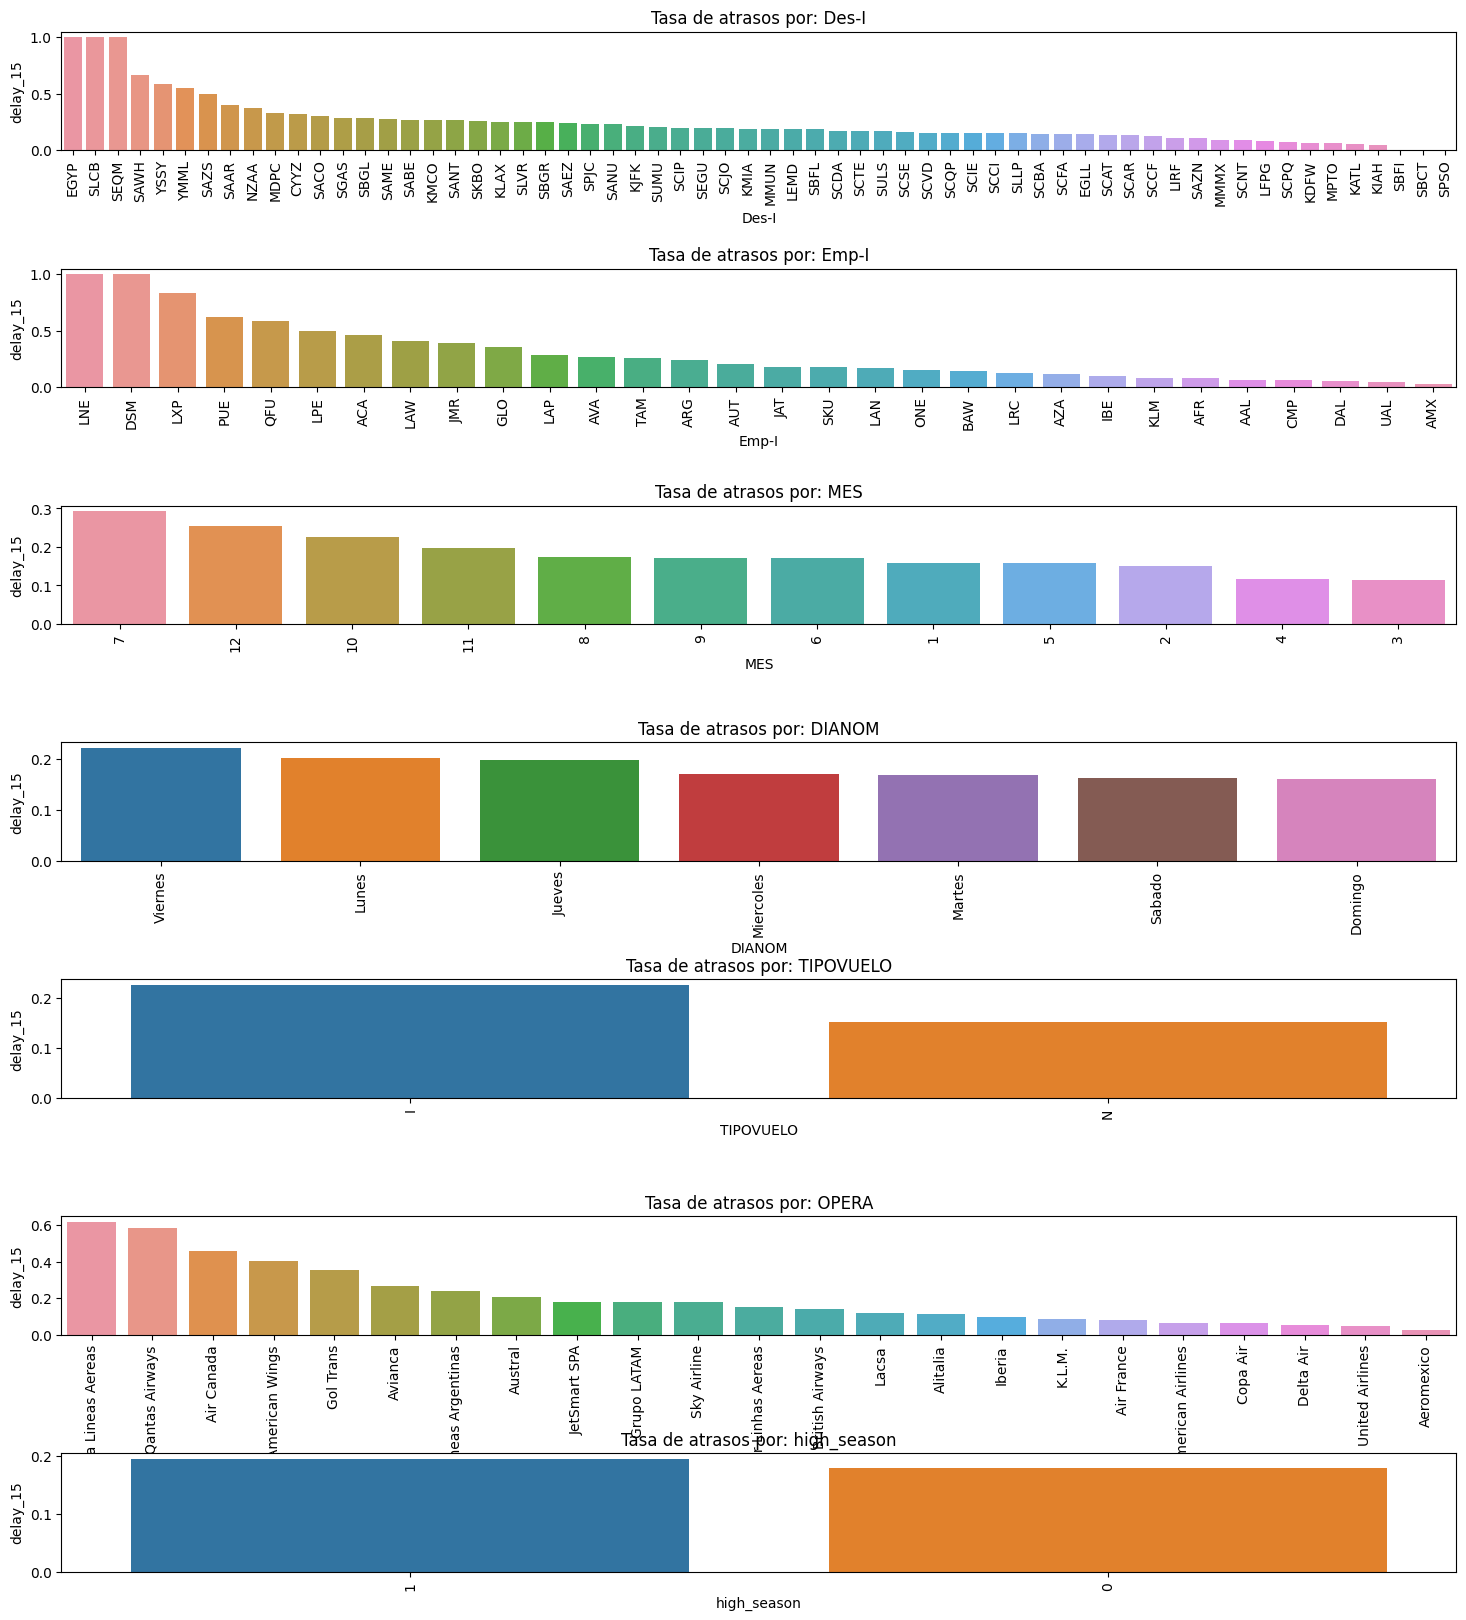

In [16]:
cols = ['Des-I', 'Emp-I',  'MES', 'DIANOM', 'TIPOVUELO', 'OPERA', 'high_season']

# grilla de subplots
fig, axs = plt.subplots(7, 1, figsize=(18,20))
axs = axs.ravel() 

# Para cada columna menos la primera hacer un grafico.
a = 0
for i in cols:
    sub_cols = [i, 'delay_15']
    df = new_data[sub_cols].groupby(i)['delay_15'].mean().reset_index().sort_values(by = 'delay_15', ascending= False)
    
    sns.barplot(data=df,x= i ,y="delay_15", orient = 'v', ax=axs[a])
    # titulo
    axs[a].set_title(f"Tasa de atrasos por: {i}")
    axs[a].set_xticklabels(axs[a].get_xticklabels(), rotation=90)
    a = a + 1
    
# justar el espaciado entre los subplots
plt.subplots_adjust(hspace=1, wspace=0.3)

plt.show()

## Creación de nuevas variables: Falta agregar contexto del momento en el que ocurre el atraso, para ello se crean variables que describen la situación actual de atrasos en las ultimas 24 y 6 horas o de vuelos programados para las siguientes horas. Las variables creadas son:

- Delay_rate_6H : Tasa de atrasos en las últimas 6 horas antes del vuelo programado.

- N_scheduled_flights_24H:  Cantidad de vuelos programados cualquiera para las siguientes 24 horas.

- N_scheduled_flights_same_place_24H:  Cantidad de vuelos programados para el mismo lugar durante las siguientes 24 horas.

- N_scheduled_flights_same_opera_24H: Cantidad de vuelos programados para la misma compañia durante las siguientes 24 horas.

- Emp_delay_rate_6H: Tasa de atrasos de los vuelos de la misma aerolinea en las últimas 6 horas antes del vuelo programado.

- Des_delay_rate_6H: Tasa de atrasos de los vuelos al mismo lugar en las últimas 6 horas antes del vuelo programado.

- Emp_change_rate_6H: Vuelos que cambiaron su Emp 6 hrs / Vuelos totales últimas 6 hrs.

In [17]:
###############: ADVERTENCIA ###############: Este bloque toma alrededor de 25 a 30 minutos en mi computador.



# # Variable que tiene la tasa de atrasos en las ultimas 24 horas antes del vuelo programado
# new_data['delay_rate_24H'] = new_data.apply(lambda x: new_data[(new_data['Fecha-I'] > x['Fecha-I'] - pd.Timedelta(hours=24)) & 
#                                                                (new_data['Fecha-I'] < x['Fecha-I'])]['delay_15'].mean(), axis=1)

# # Variable que tiene la tasa de atrasos en las ultimas 12 horas antes del vuelo programado
# new_data['delay_rate_12H'] = new_data.apply(lambda x: new_data[(new_data['Fecha-I'] > x['Fecha-I'] - pd.Timedelta(hours=12)) & 
#                                                                (new_data['Fecha-I'] < x['Fecha-I'])]['delay_15'].mean(), axis=1)

# Variable que tiene la tasa de atrasos en las ultimas 6 horas antes del vuelo programado
new_data['delay_rate_6H'] = new_data.apply(lambda x: new_data[(new_data['Fecha-I'] > x['Fecha-I'] - pd.Timedelta(hours=6)) & 
                                                              (new_data['Fecha-I'] < x['Fecha-I'])]['delay_15'].mean(), axis=1)

# Variable que tiene la cantidad de vuelos programados cualquiera para las siguientes 24 horas
new_data['N_scheduled_flights_24H'] = new_data.apply(lambda x: new_data[(new_data['Fecha-I'] < x['Fecha-I'] + pd.Timedelta(hours=24)) & 
                                                                        (new_data['Fecha-I'] > x['Fecha-I'])]['Vlo-I'].count(), axis=1)

# Variable que tiene la cantidad de vuelos programados para el mismo lugar en las siguientes 24 horas
new_data['N_scheduled_flights_same_place_24H'] = new_data.apply(lambda x: new_data[(new_data['Fecha-I'] < x['Fecha-I'] + pd.Timedelta(hours=24)) & 
                                                                        (new_data['Fecha-I'] > x['Fecha-I']) & 
                                                                        (new_data['Des-I'] == x['Des-I'])]['Vlo-I'].count(), axis=1)
# Variable que tiene la cantidad de vuelos programados para con la misma aerolinea en las siguientes 24 horas
new_data['N_scheduled_flights_same_opera_24H'] = new_data.apply(lambda x: new_data[(new_data['Fecha-I'] < x['Fecha-I'] + pd.Timedelta(hours=24)) & 
                                                                        (new_data['Fecha-I'] > x['Fecha-I']) & 
                                                                        (new_data['OPERA'] == x['OPERA'])]['Vlo-I'].count(), axis=1)

# Variable que tiene la tasa de atrasos de los vuelos de la misma aerolinea en las ultimas 6 horas antes del vuelo programado
new_data['Emp_delay_rate_6H'] = new_data.apply(lambda x: new_data[(new_data['Fecha-I'] > x['Fecha-I'] - pd.Timedelta(hours=6)) & 
                                                              (new_data['Fecha-I'] < x['Fecha-I']) &
                                                              (new_data['Emp-I'] == x['Emp-I'])
                                                              ]['delay_15'].mean(), axis=1)

# Variable que tiene la tasa de atrasos de los vuelos al mismo lugar en las ultimas 6 horas antes del vuelo programado
new_data['Des_delay_rate_6H'] = new_data.apply(lambda x: new_data[(new_data['Fecha-I'] > x['Fecha-I'] - pd.Timedelta(hours=6)) & 
                                                              (new_data['Fecha-I'] < x['Fecha-I']) &
                                                              (new_data['Des-I'] == x['Des-I'])
                                                              ]['delay_15'].mean(), axis=1)

# Variable que tiene la proporción de vuelos que han cambiado de aerolinea con respecto al total en las ultimas 6 horas antes del vuelo programado

# Vuelos que cambiaron su Emp 6 hrs / Vuelos totales ultimas 6 hrs
new_data['N_Emp_change_6H'] = new_data.apply(lambda x: len(new_data[(new_data['Fecha-I'] > x['Fecha-I'] - pd.Timedelta(hours=6)) & 
                                                              (new_data['Fecha-I'] < x['Fecha-I']) &
                                                              (new_data['Emp-I'] != x['Emp-O'])
                                                              ])
                                                              , axis=1)

# Vuelos totales ultimas 6 hrs                                                              
new_data['N_flights_6H'] = new_data.apply(lambda x: len(new_data[(new_data['Fecha-I'] > x['Fecha-I'] - pd.Timedelta(hours=6)) & 
                                                              (new_data['Fecha-I'] < x['Fecha-I'])
                                                              ])
                                                              ,axis=1)

#Vuelos que cambiaron su Emp 6 hrs / Vuelos totales ultimas 6 hrs

new_data['Emp_change_rate_6H'] = new_data['N_Emp_change_6H']/new_data['N_flights_6H']

## Distribución de las nuevas variables

- Se probó el delay rate con 24, 12 y 6 horas. para el caso de 6 horas se obtuvo la mayor diferenciación entre la variable target. Deje comentados los calculos de 24 y 12 horas para que el código no tome tanto tiempo en correr. Podría seguir experimentando con 3 o menos horas pero asumiré que el modelo debe tener cierto delay para realizar alguna acción y por lo tanto fijaré 6 horas como el minimo.

- Para las variables sobre la cantidad de vuelos agendados en las PRÓXIMAS 24 horas no se observó una diferenciación clara en los boxplot, no serán incluidas.

- Des_delay_rate_6H y Emp_delay_rate_6H presentan una variación importante con respecto al target, se incluiran ambas al dataset. Emp_change_rate_6H tiene una variación pequeña de todas formas se agregará de forma experimental.

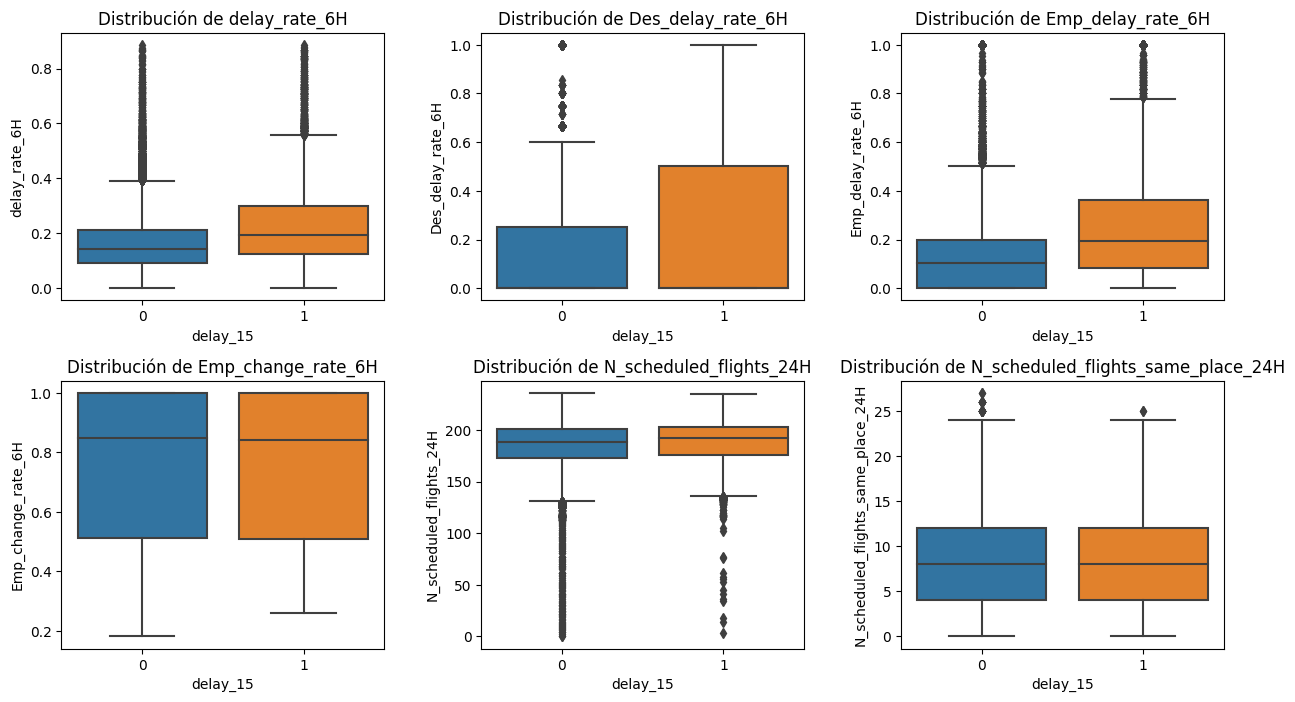

In [18]:
cols = ['delay_15' ,'delay_rate_6H','Des_delay_rate_6H' ,'Emp_delay_rate_6H','Emp_change_rate_6H','N_scheduled_flights_24H', 'N_scheduled_flights_same_place_24H']
df = new_data[cols].copy()

# grilla de subplots
fig, axs = plt.subplots(2, 3, figsize=(15,8))
axs = axs.ravel() 

# Para cada columna menos la primera hacer un grafico.
a = 0
for i in cols[1:]:
    sns.boxplot(x='delay_15', y=i, data=df, ax=axs[a])
    
    # titulo
    axs[a].set_title(f"Distribución de {i}")
    a = a + 1
# ajustar el espaciado entre los subplots
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.show()

# 4.- Entrena uno o varios modelos (con los algoritmos que tu quieras) para estimar la probabilidad de un vuelo con atraso. Puedes generar cuantas variables quieras y/o suplementar con datos externos.

- Por simplicidad y facilidad de entender usaré una regresión logistica. Aplicaré gridseach para buscar el mejor valor del regularizador "C" y k-folds sobre un training set, se reserva un test set para revisar el rendimiento del modelo. 

- Para variables categóricas usaré one hot encoder. Seria ideal que en el dataset se encuentren todos los posibles valores, asumiré que es asi.

- Para el one hot encoding se ignorará un valor por cada feature, esto para evitar redundancia.

In [23]:
features = [
'DIA', 'MES', 'DIANOM', 'TIPOVUELO',
'OPERA', 'high_season',
'period_day', 'delay_rate_6H', 'delay_15', 'Emp_delay_rate_6H',
'Des_delay_rate_6H', 'Emp_change_rate_6H'
]

cat_features = [
'MES', 'DIANOM', 'TIPOVUELO',
'OPERA', 'high_season',
'period_day'
]

num_features = [
'delay_15', 'delay_rate_6H', 'Emp_delay_rate_6H','Des_delay_rate_6H','Emp_change_rate_6H'
]

# Crear encoder
encoder = OneHotEncoder(drop = 'first')

encoder.fit(new_data[cat_features])


print(f"Variables categoricas en formato one hot: \n{encoder.categories_}")

#Al crear la funcion de delay ultimas 6 horas se genera siempre 1 nulo (el primer valor segun fecha) y tambien se sesgan las filas que no sean mayores a 6 horas sobre el minimo.
new_data = new_data.dropna()
#Asegurar que el dataset tenga al menos 6 horas de historia
dataset = new_data[new_data['Fecha-I'] >= new_data['Fecha-I'].min() + pd.Timedelta(hours=6)].copy()

#Variables categoricas a utilizar
all_cat_features = []
for i in encoder.categories_:
    all_cat_features.extend(i[1:])


#Transformacion de los datos con el encoder
X_cat = encoder.transform(new_data[cat_features]).toarray()
X_num = new_data[num_features].to_numpy()

#Concatenar features numericas y categoricos
X = np.concatenate((X_num, X_cat), axis=1)
np.shape(X)

# todas las columnas
cols_name = num_features + all_cat_features

#Dataframe en formato one hot para las categoricas
df_one_hot = pd.DataFrame(X, columns = cols_name)

#Se define el target como la variable delay_15
target = df_one_hot['delay_15']

#Pesos de la variable, estos se utilizaran en el modelo.
weight = class_weight.compute_class_weight('balanced', 
                                            classes = [0,1], 
                                            y = target)
                                            

print(f"Pesos de la variable target: {weight}")

Variables categoricas en formato one hot: 
[array(['1', '10', '11', '12', '2', '3', '4', '5', '6', '7', '8', '9'],
      dtype=object), array(['Domingo', 'Jueves', 'Lunes', 'Martes', 'Miercoles', 'Sabado',
       'Viernes'], dtype=object), array(['I', 'N'], dtype=object), array(['Aerolineas Argentinas', 'Air Canada', 'American Airlines',
       'Avianca', 'Copa Air', 'Gol Trans', 'Grupo LATAM', 'JetSmart SPA',
       'Latin American Wings', 'Plus Ultra Lineas Aereas', 'Sky Airline'],
      dtype=object), array(['0', '1'], dtype=object), array(['afternoon', 'morning', 'night'], dtype=object)]
Pesos de la variable target: [0.61131561 2.74586657]


## Partición en training y test

In [50]:
#La primera columna era el target, por lo tanto se elimina del dataset predictivo
pred_features = cols_name[1:]

#Semilla de procesos pseudoaleatorios
seed = 100

#Creacion train y test

x_train, x_test, y_train, y_test = train_test_split(df_one_hot[pred_features], 
                                    target, test_size=0.1, 
                                    random_state= seed, stratify = target)


# Variable target
y_train = np.array(y_train.astype('int'))
y_test = np.array(y_test.astype('int'))

# Entrenamiento del modelo

In [51]:
#Inicialización del modelo 
model = LogisticRegression(
                        class_weight = {0: 0.61131561 , 1: 2.74586657}, 
                        random_state = seed,
                        max_iter = 1000
                        )

grid = {
        'C': [0.001 , 0.01, 0.05 ,0.1 , 0.25 , 0.5 , 1, 10],
        'penalty': ['l2']
        }

grid_search = GridSearchCV(
    model, 
    grid, 
    cv = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed),
    scoring = 'roc_auc'
    )

kfolds = StratifiedKFold(
    n_splits = 5, 
    shuffle = True, 
    random_state = seed
    )

AUC_list = []

# Para cada fold 
for train_index, test_index in kfolds.split(x_train, y_train):

    X_train_fold, X_test_fold = x_train.iloc[train_index], x_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    grid_search.fit(X_train_fold, y_train_fold)
    y_pred = grid_search.predict_proba(X_test_fold)[:,1]
    AUC_list.append(roc_auc_score(y_test_fold, y_pred))

# Área bajo la curva ROC para cada fold y el promedio entre todos
print("AUC de cada fold:", AUC_list)
print("Promedio de los AUC:", np.mean(AUC_list))

# Mejores parámetros obtenidos
print("Mejores parámetros:", grid_search.best_params_)

AUC de cada fold: [0.7084614204074705, 0.7177111968377223, 0.7016090317310614, 0.7030506452100282, 0.7140938391467485]
Promedio de los AUC: 0.7089852266666062
Mejores parámetros: {'C': 0.5, 'penalty': 'l2'}


In [56]:
#Se entrena el modelo utilizando todo el training set con el mejor valor para C encontrado
best_model = LogisticRegression(
                        class_weight = {0: 0.61131561 , 1: 2.74586657}, 
                        random_state = seed,
                        max_iter = 1000,
                        C = 0.5,
                        penalty = 'l2'
                        ) 

best_model.fit(x_train, y_train)

y_train_pred = best_model.predict_proba(x_train)[:,1]
y_test_pred = best_model.predict_proba(x_test)[:,1]

print(f"ROC para training {roc_auc_score(y_train, y_train_pred)}") 
print(f"ROC para test {roc_auc_score(y_test, y_test_pred)}")   


ROC para training 0.7109278246172572
ROC para test 0.694812864061419


# 5. Evalua el rendimiento del modelo predictivo. Define y justifica las metricas usadas para ello. Elige el mejor modelo y evalua lo siguiente: Cuales fueron las mejores variables predictivas? Cómo podrias mejorar el rendimiento?